Processing offset: 0.125
Processing offset: 0.25
Processing offset: 0.375
Processing offset: 1


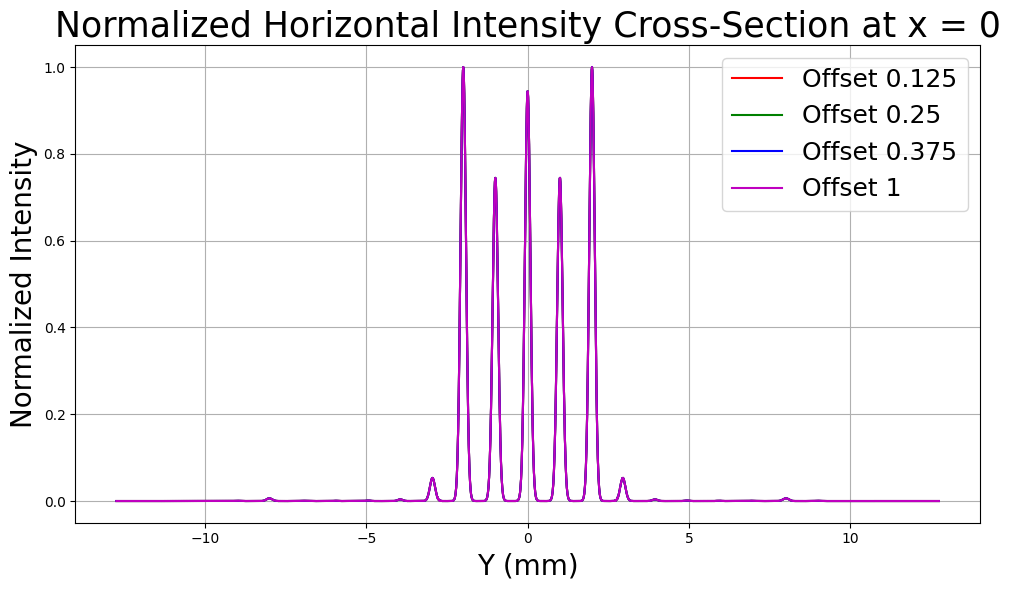

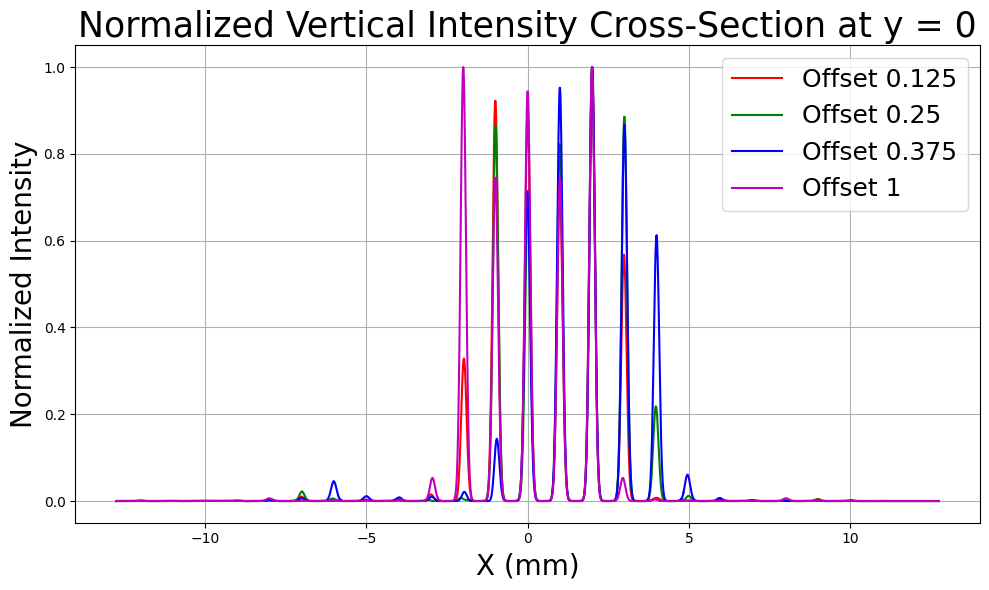

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from skimage import measure

# Manually assign a name since __file__ is not available in Jupyter
file = 'Microlensarray'  # You can change this as needed
File = os.path.splitext(file)[0]

# Angular Spectrum Method with Padding and Bandwidth Limiting
def angular_spectrum_method_with_padding_zarray(field, z_arr, wavelength, dx, dy, pad_width, alpha, bandwidth_limit=True):
    k = 2 * np.pi / wavelength  # Wave number

    # Padding the input field
    padded_field = np.pad(field, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

    # Creating an absorption mask
    Nx, Ny = padded_field.shape
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    absorption_mask = np.exp(-alpha * np.maximum(r - 1 + 2 * pad_width / max(Nx, Ny), np.zeros_like(r))**2)

    # Applying the absorption mask
    padded_field *= absorption_mask

    # Fourier Transform of the input field
    field_ft = np.fft.fft2(padded_field)

    # Spatial frequencies
    kx = np.fft.fftfreq(Nx, dx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, dy) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing="ij")

    # Bandwidth limiting
    if bandwidth_limit:
        k_max = k
        mask = (kx**2 + ky**2 <= k_max**2)
        field_ft *= mask

    # kz in the frequency domain
    kz = np.sqrt(np.clip(k**2 - kx**2 - ky**2, 0, None))

    propagated_fields = np.empty((len(z_arr), field.shape[0], field.shape[1]), dtype=np.complex128)
    for count, z in enumerate(z_arr):  # Looping over z
        # Propagation phase factor
        phase_factor = np.exp(1j * kz * z)

        # Propagated field in the frequency domain
        propagated_field_ft = field_ft * phase_factor

        # Inverse Fourier Transform to get the field at distance z
        propagated_field = np.fft.ifft2(propagated_field_ft)

        # Removing padding
        propagated_field = propagated_field[pad_width:Nx-pad_width, pad_width:Ny-pad_width]
        propagated_fields[count, :, :] = propagated_field

    return propagated_fields

# Fourier lens phase function
def fourier_lens(X, Y, f, wavelength):
    phase = -np.pi / (wavelength * f) * (X**2 + Y**2)
    return phase

# Parabolic phase function for a single lens
def parabolic_phase(X, Y, f, wavelength):
    phase = -np.pi / (wavelength * f) * (X**2 + Y**2)
    return phase

# Micro-lens array generation without offset (MLA1)
def micro_lens_array1(num_lenses, lens_diameter, single_grid, grid_size_per_lens, focal_length, wavelength, x0):
    total_grid_size = grid_size_per_lens * num_lenses
    phase_shift_array = np.zeros((total_grid_size, total_grid_size))

    for i in range(num_lenses):
        for j in range(num_lenses):
            x_offset = (i - num_lenses // 2) * lens_diameter
            y_offset = (j - num_lenses // 2) * lens_diameter
            x = np.linspace(-single_grid / 2, single_grid / 2, grid_size_per_lens) 
            y = np.linspace(-single_grid / 2, single_grid / 2, grid_size_per_lens) 
            X, Y = np.meshgrid(x, y)
            phase_shift = parabolic_phase(X, Y, focal_length, wavelength)

            start_idx_x = i * grid_size_per_lens
            start_idx_y = j * grid_size_per_lens
            phase_shift_array[start_idx_x:start_idx_x + grid_size_per_lens, start_idx_y:start_idx_y + grid_size_per_lens] = phase_shift

    return phase_shift_array

# Modified micro-lens array function for multiple offsets
def micro_lens_array2_varying_offset(num_lenses, lens_diameter, single_grid, grid_size_per_lens, focal_length, wavelength, x0, offsets):
    total_grid_size = grid_size_per_lens * num_lenses
    phase_shift_arrays = []

    for offset in offsets:
        phase_shift_array = np.zeros((total_grid_size, total_grid_size))

        for i in range(num_lenses):
            for j in range(num_lenses):
                x_offset = (i - num_lenses // 2) * lens_diameter
                y_offset = (j - num_lenses // 2) * lens_diameter
                x = np.linspace(-single_grid / 2, single_grid / 2, grid_size_per_lens)
                y = np.linspace(-single_grid / 2, single_grid / 2, grid_size_per_lens) 
                X, Y = np.meshgrid(x, y)
                phase_shift = parabolic_phase(X, Y, focal_length, wavelength)

                # Starting indices with specified offset
                start_idx_x = i * grid_size_per_lens
                start_idx_y = int(j * grid_size_per_lens + (offset*grid_size_per_lens))
                end_idx_x = start_idx_x + grid_size_per_lens
                end_idx_y = start_idx_y + grid_size_per_lens

                # Ensure the indices stay within bounds
                if end_idx_x <= total_grid_size and end_idx_y <= total_grid_size:
                    phase_shift_array[start_idx_x:end_idx_x, start_idx_y:end_idx_y] = phase_shift

        phase_shift_arrays.append(phase_shift_array)

    return phase_shift_arrays

def propagation_phase_element(field, phase_shift, z_array, wavelength, dx, dy, pad_width, alpha):
    fieldn = field * np.exp(1j * phase_shift)
    output_field = angular_spectrum_method_with_padding_zarray(fieldn, z_array, wavelength, dx, dy, pad_width, alpha, bandwidth_limit=True)
    return output_field

# Parameters (in millimeters)
focal_length = 46.5  # mm
focal_lengthp = 46.5  # mm
focal_lengthFL = 500  # mm
wavelength = 1e-3  # mm

grid_size_per_lens = 50  # Number of cells across a lens diameter
num_lenses = 51  # Number of lenses per side
single_grid = 500e-3  # mm (Assuming this represents some scaling factor)
lens_diameter = single_grid * num_lenses  # mm

wb = 0.94  # beam width

# Total grid size for the array
total_grid_size = grid_size_per_lens * num_lenses

# Initialize the grid for the entire array
xx = np.linspace(-lens_diameter / 2, lens_diameter / 2, total_grid_size)
yy = np.linspace(-lens_diameter / 2, lens_diameter / 2, total_grid_size)
XX, YY = np.meshgrid(xx, yy)

pad_width = 140  # Padding width
alpha = 16  # Absorption coefficient
dx = xx[1] - xx[0]
dy = dx

# Initialize the input field
field = num_lenses * np.exp(-(XX**2 + YY**2) / wb**2)

# Generate phase shift array for MLA1
phase_shift_array_MLA1 = micro_lens_array1(num_lenses, lens_diameter, single_grid, grid_size_per_lens, focal_length, wavelength, 0)

# Define propagation distances for MLA1
z_arr_MLA1 = np.array([0, 1, focal_lengthp])

# Propagation through the first MLA
output_MLA1 = propagation_phase_element(field, phase_shift_array_MLA1, z_arr_MLA1, wavelength, dx, dy, pad_width, alpha)

# Define offsets for the second MLA
offsets = [1/8, 1/4, 3/8, 1]  # 50 corresponds to grid_size_per_lens

# Get the phase shift arrays for the varying offsets
phase_shift_arrays_MLA2 = micro_lens_array2_varying_offset(
    num_lenses, lens_diameter, single_grid, grid_size_per_lens, 
    focal_length, wavelength, single_grid/2, offsets
)

# Initialize lists to store cross-section data
cross_section_x = {offset: None for offset in offsets}
cross_section_y = {offset: None for offset in offsets}

# Define colors for plotting
colors = ['r', 'g', 'b', 'm']  # Adjust as needed
color_map = dict(zip(offsets, colors))

# Loop over each phase shift array with different offsets
for i, (offset, phase_shift_array_MLA2) in enumerate(zip(offsets, phase_shift_arrays_MLA2)):
    print(f"Processing offset: {offset}")

    # Define propagation distances for MLA2
    z_arr_MLA2 = np.array([0, 1, focal_lengthFL - focal_lengthp])

    # Propagation through the second MLA with current offset
    output_MLA2 = propagation_phase_element(
        output_MLA1[-1, :, :], phase_shift_array_MLA2, 
        z_arr_MLA2, wavelength, dx, dy, pad_width, alpha
    )

    # Fourier lens phase for propagation
    fourier_lens_phase = fourier_lens(XX, YY, focal_lengthFL, wavelength)

    # Define propagation distances for Fourier lens
    z_arr_FL = np.array([0, focal_lengthFL, 2 * focal_lengthFL])

    # Propagation through the Fourier lens
    output_FL1 = propagation_phase_element(
        output_MLA2[-1, :, :], fourier_lens_phase, 
        z_arr_FL, wavelength, dx, dy, pad_width, alpha
    )

    # Intensity at the focal plane of the Fourier lens
    intensity = np.abs(output_FL1[1, :, :])**2

    # Intensity cross-sections along x = 0 and y = 0
    x_index = np.argmin(np.abs(xx))  # Closest index to x = 0
    y_index = np.argmin(np.abs(yy))  # Closest index to y = 0

    # Horizontal cross-section (y at x=0)
    intensity_curve_x = intensity[:, x_index]
    intensity_curve_x_normalized = intensity_curve_x / np.max(intensity_curve_x)
    cross_section_x[offset] = (yy, intensity_curve_x_normalized)

    # Vertical cross-section (x at y=0)
    intensity_curve_y = intensity[y_index, :]
    intensity_curve_y_normalized = intensity_curve_y / np.max(intensity_curve_y)
    cross_section_y[offset] = (xx, intensity_curve_y_normalized)

    # Optional: Save the intensity image if needed
    # plt.figure()
    # plt.pcolormesh(xx, yy, intensity, cmap='jet')
    # plt.gca().set_aspect('equal', adjustable='box')
    # plt.title(f"Intensity at Fourier Lens Focal Plane (Offset {offset})")
    # FileFig = File + f'_Intensity_Fourier_Focal_Plane_Offset_{offset}.png'
    # plt.savefig(FileFig)
    # plt.show()

# Plot all horizontal cross-sections (y at x=0) on a single plot
plt.figure(figsize=(10, 6))
for offset in offsets:
    yy_vals, intensity_x = cross_section_x[offset]
    plt.plot(yy_vals, intensity_x, label=f'Offset {offset}', color=color_map[offset])
plt.title('Normalized Horizontal Intensity Cross-Section at x = 0', fontsize=25)
plt.xlabel('Y (mm)', fontsize=20)
plt.ylabel('Normalized Intensity', fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot all vertical cross-sections (x at y=0) on a single plot
plt.figure(figsize=(10, 6))
for offset in offsets:
    xx_vals, intensity_y = cross_section_y[offset]
    plt.plot(xx_vals, intensity_y, label=f'Offset {offset}', color=color_map[offset])
plt.title('Normalized Vertical Intensity Cross-Section at y = 0', fontsize=25)
plt.xlabel('X (mm)', fontsize=20)
plt.ylabel('Normalized Intensity', fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()
